In [1]:
import gymnasium as gym
import matplotlib
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import random
import math
from collections import namedtuple, deque
from itertools import count
from IPython.display import clear_output
from IPython import display

import torch
import torch.nn as nn
import torch.optim as optim
import torch.nn.functional as F
from torch.distributions import Categorical

is_ipython = 'inline' in matplotlib.get_backend()

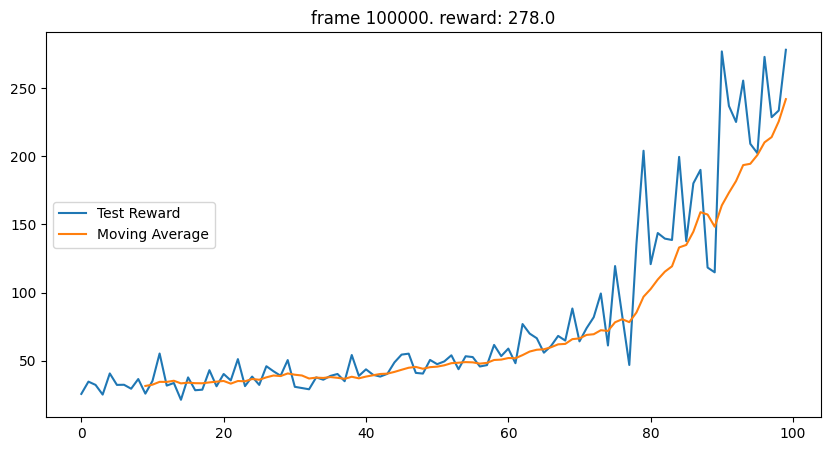

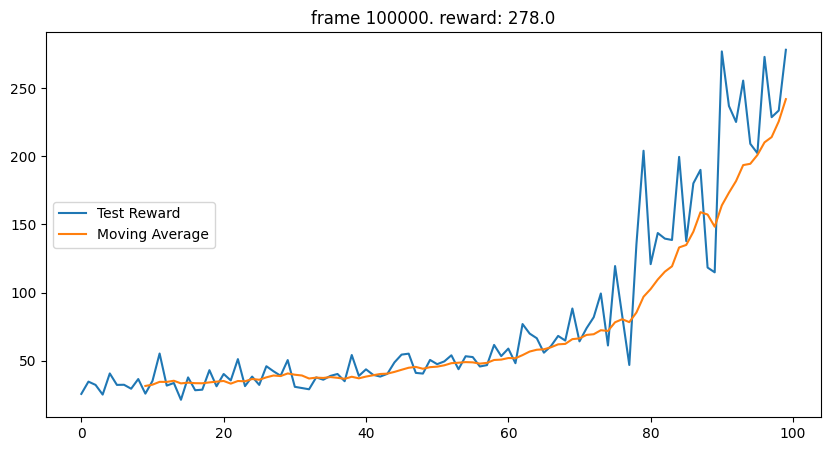

In [3]:
device = torch.device("cpu")

class PPO(nn.Module):
    def __init__(self, num_inputs, num_outputs, hidden_size, std=0.0):
        super(PPO, self).__init__()

        self.critic = nn.Sequential(
            nn.Linear(num_inputs, hidden_size),
            nn.ReLU(),
            nn.Linear(hidden_size, 1)
        )

        self.actor = nn.Sequential(
            nn.Linear(num_inputs, hidden_size),
            nn.ReLU(),
            nn.Linear(hidden_size, num_outputs),
            nn.Softmax(dim=1),
        )

    def forward(self, x):
        value = self.critic(x)
        probs = self.actor(x)
        dist  = Categorical(probs)
        return dist, value

def compute_returns(next_value, rewards, masks, gamma=0.99):
    R = next_value
    returns = []
    for step in reversed(range(len(rewards))):
        R = rewards[step] + gamma * R * masks[step]
        returns.insert(0, R)
    return returns

def test_env(model):  # Add `model` as an argument
    state, _ = env.reset()
    done = False
    total_reward = 0
    while not done:
        state_tensor = torch.tensor(state, dtype=torch.float32, device=device).unsqueeze(0)
        dist, _ = model(state_tensor)
        action = dist.sample()
        state, reward, done, _, _ = env.step(action.cpu().numpy()[0])
        total_reward += 1
    return total_reward
fig, ax = plt.subplots(figsize=(10,5))

def plot(frame_idx, rewards, predictions):
    ax.clear()  # Clear previous plot
    ax.plot(rewards, label='Test Reward')
    ax.plot(predictions, label='Moving Average')
    ax.set_title('frame %s. reward: %s' % (frame_idx, rewards[-1]))
    ax.legend(loc='center left')
    display.clear_output(wait=True)
    display.display(plt.gcf()) # Pause to allow the plot to update


plt.ion()

def train_ppo(env):
    num_inputs  = env.observation_space.shape[0]
    num_outputs = env.action_space.n

    model = PPO(num_inputs, num_outputs, hidden_size=256).to(device)
    optimizer = optim.Adam(model.parameters())

    max_frames   = 100000
    frame_idx    = 0
    test_rewards = []

    while frame_idx < max_frames:
        state, _ = env.reset()
        log_probs = []
        values    = []
        rewards   = []
        masks     = []
        entropy = 0

        for _ in range(100):
            state_tensor = torch.tensor(state, dtype=torch.float32, device=device).unsqueeze(0)
            dist, value = model(state_tensor)

            action = dist.sample()
            next_state, reward, done, _, _ = env.step(action.cpu().numpy()[0])

            log_prob = dist.log_prob(action)
            entropy += dist.entropy().mean()

            log_probs.append(log_prob)
            values.append(value)
            rewards.append(torch.tensor([reward], dtype=torch.float))
            masks.append(torch.tensor([1-done], dtype=torch.float))

            state = next_state
            frame_idx += 1

        next_state = torch.FloatTensor(next_state).unsqueeze(0)
        _, next_value = model(next_state)
        returns = compute_returns(next_value, rewards, masks)

        log_probs = torch.cat(log_probs)
        returns   = torch.cat(returns).detach()
        values    = torch.cat(values)

        advantage = returns - values

        actor_loss  = -(log_probs * advantage.detach()).mean()
        critic_loss = advantage.pow(2).mean()

        loss = actor_loss + 0.5 * critic_loss - 0.001 * entropy

        optimizer.zero_grad()
        loss.backward()
        optimizer.step()

        if frame_idx % 1000 == 0:
            test_rewards.append(np.mean([test_env(model) for _ in range(10)]))
            moving_average = pd.Series(test_rewards).rolling(window=10).mean().tolist()  # Use a window of 10 for the moving average
            plot(frame_idx, test_rewards, moving_average)

env = gym.make("CartPole-v1")
train_ppo(env)